In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Sep 30 09:06:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


-------------

In [3]:
import sys, os
if 'google.colab' in sys.modules:
    # https://github.com/yandexdataschool/Practical_RL/issues/256
    !pip uninstall tensorflow --yes
    !pip uninstall keras --yes
    !pip install tensorflow-gpu==1.13.1
    !pip install keras==2.2.4
    
    if not os.path.exists('.setup_complete'):
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
        !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

!pip install box2d-py


Uninstalling tensorflow-2.3.0:
  Successfully uninstalled tensorflow-2.3.0
Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 345.2MB 52kB/s 
     |████████████████████████████████| 368kB 58.1MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 3.2MB 58.3MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
     |████████████████████████████████| 317kB 4.5MB/s 
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.
Selecting previously unselected package xvfb.
(Reading database ... 144619 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.6_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.

### Let's make a TRPO!

In this notebook we will write the code of the one Trust Region Policy Optimization.
As usually, it contains a few different parts which we are going to reproduce.



In [6]:
import tensorflow as tf
from tensorflow.keras import layers

import gym
import numpy as np


In [7]:
env = gym.make('LunarLanderContinuous-v2')
env.reset()

dim_state = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(dim_state))

dim_action = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(dim_action))

lower_bound = env.action_space.low[0]
upper_bound = env.action_space.high[0]

print("Min Value of Action ->  {}".format(lower_bound))
print("Max Value of Action ->  {}".format(upper_bound))

Size of State Space ->  8
Size of Action Space ->  2
Min Value of Action ->  -1.0
Max Value of Action ->  1.0


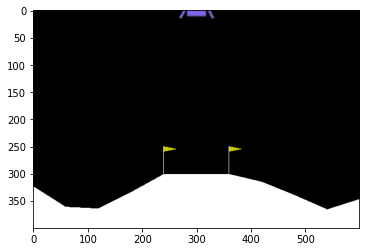

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(env.render('rgb_array'))
plt.show()

### Step 1: Defining a network

With all it's complexity, at it's core TRPO is yet another policy gradient method. 

This essentially means we're actually training a stochastic policy $ \pi_\theta(a|s) $. 

And yes, it's gonna be a neural network. So let's start by defining one.

In [9]:
tf.reset_default_graph()

# Unknown Time dimention = None

# input tensors
obs_ph  = tf.placeholder(shape=(None, dim_state), dtype=tf.float32)

# 
p_beta_ph = tf.placeholder(shape=(), dtype=tf.float32)
v_beta_ph = tf.placeholder(shape=(), dtype=tf.float32)

# Actions that we made
actions_ph   = tf.placeholder(shape=(None, dim_action), dtype=tf.float32)

# Previous Model "mu" prediction
old_mu_ph    = tf.placeholder(shape=(None, dim_action), dtype=tf.float32)
old_V_ph     = tf.placeholder(shape=(None, ), dtype=tf.float32)

# Action probabilities from previous iteration
old_probs_ph = tf.placeholder(shape=(None, ), dtype=tf.float32)

# GAE
advantage_ph = tf.placeholder(shape=(None, ), dtype=tf.float32)

# Cumulative Return "G = r + gamma*r' + gamma^2*r'' + ..."
c_returns_ph = tf.placeholder(shape=(None, ), dtype=tf.float32)

# Sigma is an input parameter!
sigma_sq = (2 ** 2) * tf.ones((dim_action, ), dtype=tf.float32)


Multivariate Gaussian PDF: 

TF and np functions

In [10]:
def tf_normal(s, mu, sigma_sq):
    exp_term   = tf.math.exp( - tf.reduce_sum( tf.math.square(s - mu) / (2 * sigma_sq), axis = -1) )
    norm_const = tf.math.sqrt( tf.math.pow(2 * np.pi, dim_action) * tf.reduce_prod(sigma_sq, axis=-1) )
    return exp_term / norm_const


def normal(s, mu, sigma_sq):
    exp_term   = np.exp( - np.sum( np.square(s - mu) / (2 * sigma_sq), axis = -1) )
    norm_const = np.sqrt( np.pow(2 * np.pi, dim_action) * np.prod(sigma_sq, axis=-1) )
    return exp_term / norm_const


def sample_action(mu, sigma_sq):
    action = mu + np.sqrt(sigma_sq) * np.random.randn( mu.shape[0] )
    return action


In [11]:
def denselayer(name, x, out_dim, nonlinearity=None):
    with tf.variable_scope(name):
        if nonlinearity is None:
            nonlinearity = tf.identity

        W = tf.get_variable('W', shape=[x.shape[1], out_dim])
        b = tf.get_variable('b', shape=[out_dim], 
                            initializer = tf.compat.v1.random_normal_initializer(mean=0.0, stddev=0.05))
        o = nonlinearity(tf.matmul(x, W) + b)
        return o


# Interactive Session
sess = tf.InteractiveSession()

# NN for prediction of mu
nn = denselayer("policy_layer_1", obs_ph, 64, tf.nn.tanh)
nn = denselayer("policy_layer_2", nn, 64, tf.nn.tanh)
nn = denselayer("policy_layer_3", nn, 64, tf.nn.tanh)
mu = denselayer("policy", nn, dim_action, tf.nn.tanh)

# Actions
probs_ph = tf_normal(actions_ph, mu, sigma_sq)

# NN for prediction of V
nn  = denselayer("value_layer_1", obs_ph, 64, tf.nn.relu)
nn  = denselayer("value_layer_2", nn, 64, tf.nn.relu)
nn  = denselayer("value_layer_3", nn, 64, tf.nn.relu)
V   = denselayer("value", nn, 1, None)

# Get Trainable Variables
train_vars = tf.trainable_variables()


Instructions for updating:
Colocations handled automatically by placer.


### Step 3: loss functions

Now let's define the loss functions and constraints for actual TRPO training.

Advantage:
$$A_{\theta_{old}}(s_{i},a_{i})=G_{\theta_{old}}(s_{i},a_{i})-V_{\theta_{old}}(s_{i})$$

where the gain function is
$$G_{\theta_{old}}(s_{i},a_{i})=\sum_{j=i}^{T}\gamma^{j-i}r_{j}$$

The surrogate reward should be
$$J_{surr}= {1 \over N} \sum\limits_{i=0}^N \frac{\pi_{\theta}(s_i, a_i)}{\pi_{\theta_{old}}(s_i, a_i)}
A_{\theta_{old}}(s_{i},a_{i})$$

Clip Loss Function
$$L_{\theta_{old}}^{CLIP}(\theta)=\frac{1}{N}\sum\limits _{i=0}^{N}\min\left\{ \frac{\pi_{\theta}(s_{i},a_{i})}{\pi_{\theta_{old}}(s_{i},a_{i})}A_{\theta_{old}}(s_{i},a_{i}),\ g\left(\epsilon,A_{\theta_{old}}(s_{i},a_{i})\right)\right\}$$

where function
$$g(\epsilon,A)=\begin{cases}
(1+\epsilon)A & ,\text{ if }A\geq0\\
(1-\epsilon)A & ,\text{ o.w.}
\end{cases}$$

Or alternatively, minimize the surrogate loss:
$$ L_{surr} = - L_{\theta_{old}}^{CLIP}(\theta) $$

In [12]:
# Compute surrogate loss: negative importance-sampled policy gradient
batch_size = tf.cast(tf.shape(mu)[0], tf.float32)

# select probabilities of chosen actions
probs_all     = tf.reshape(probs_ph, [-1])
old_probs_all = tf.reshape(old_probs_ph, [-1])
ratio_ph      = probs_all / old_probs_all

# clipping pattern
epsilon = 0.2
clippling_pattern = tf.minimum((1 - epsilon) * advantage_ph, 0) +\
                    tf.maximum((1 + epsilon) * advantage_ph, 0)

# Clipped Loss
L_surr = tf.reduce_mean( tf.minimum(ratio_ph * advantage_ph, clippling_pattern) )


# Value loss
V_objective = tf.reduce_mean( tf.math.square( V[:,0] - c_returns_ph ) )

ss_sq    = tf.reduce_mean( tf.math.square( old_V_ph - c_returns_ph ) )
kl_value = tf.reduce_mean( tf.math.square( V[:0] - old_V_ph ) ) / (2 * ss_sq)

V_loss = V_objective + v_beta_ph * kl_value
train_V_loss = tf.train.AdamOptimizer(1e-4).minimize(V_loss)

We can ascend these gradients as long as our $\pi_\theta(a|s)$ satisfies the constraint
$$E_{s,\pi_{\Theta_{t}}}\Big[KL(\pi(\Theta_{t}, s) \:||\:\pi(\Theta_{t+1}, s))\Big] < \alpha$$



For multivariate Guassian distributions, we have

\begin{eqnarray*}
KL\left(\pi_{t}(\cdot|s)\:||\:\pi_{t+1}(\cdot|s)\right)&=&\frac{1}{2}\left\{ -k+Tr\left[\Sigma_{t+1}^{-1}\Sigma_{t}\right]+(\mu_{t+1}-\mu_{t})^{T}\Sigma_{t+1}^{-1}(\mu_{t+1}-\mu_{t})+\ln\frac{\det(\Sigma_{t+1})}{\det(\Sigma_{t})}\right\} \\(\Sigma_{t+1}=\Sigma_{t})&=&\frac{1}{2}\left\{ (\mu_{t+1}-\mu_{t})^{T}\Sigma_{t+1}^{-1}(\mu_{t+1}-\mu_{t})\right\} \\&=&\frac{1}{2}\sum_{i=1}^{k}\left(\frac{[\mu_{t+1}-\mu_{t}]_{i}}{[\sigma_{t+1}]_{i}}\right)^{2}
\end{eqnarray*}

In [13]:
# Compute Kullback-Leibler divergence (see formula above)
# Note: you need to sum KL and entropy over all actions, not just the ones agent took

kl_policy = 0.5 * tf.reduce_sum( tf.math.square(mu - old_mu_ph) / (2 * sigma_sq))
kl_policy /= batch_size

# Compute policy entropy
log_probs_all = tf.math.log(probs_all + 1e-5)
entropy       = - tf.reduce_sum(probs_all * log_probs_all) / batch_size

# Goal is to maximize: L_surr, minimize beta_ph * kl, maximize entropy
# Since we use minimizer, we have
policy_loss       = -L_surr + p_beta_ph * kl_policy - entropy
train_Policy_loss = tf.train.AdamOptimizer(1e-4).minimize(policy_loss)

# No variable depends on the following losses
# Used only for progress tracking
#losses = [L_surr, kl_policy, entropy, kl_value]
losses = [kl_policy, kl_value]

Instructions for updating:
Use tf.cast instead.


In [14]:
# Initialize TF
sess.run(tf.global_variables_initializer())

--------------------

In [15]:
# Restore variables from disk.
saver = tf.train.Saver()
saver.restore(sess, "model.ckpt")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model.ckpt


------------------

### Step 2: Actions and rollouts

In this section, we'll define functions that take actions $ a \sim \pi_\theta(a|s) $ and rollouts $ \langle s_0,a_0,s_1,a_1,s_2,a_2,...s_n,a_n \rangle $.

In [16]:
def act(obs, sample = True):
    """
    Samples action from policy distribution (sample = True) or takes most likely action (sample = False)
    :param: obs - single observation vector
    :param sample: if True, samples from \pi, otherwise takes most likely action
    :returns: mu, V, action, prob
    """
    # obs.reshape((1, -1)) makes batch first: [[obs]]
    feed_dict = {obs_ph: obs.reshape((1, -1))}
    mu_eval, V_eval   = sess.run([mu, V], feed_dict = feed_dict)
    mu_eval = mu_eval[0]
    V_eval  = V_eval[0,0]

    # Sample action
    action = sample_action(mu_eval, sigma_sq.eval()) if sample == True else mu_eval

    # Add actions to the dictionary
    feed_dict[actions_ph] = action[None]
    prob = sess.run(probs_ph, feed_dict = feed_dict)[0]

    return mu_eval, V_eval, action, prob

Compute cummulative reward just like you did in vanilla REINFORCE

**Rollout**

In [17]:
import numpy as np

def get_GAE(r, v, v_p, gamma=1, gae_param=1):
    n   = np.shape(r)[0]
    gae = np.zeros(n, dtype=np.float32)

    d = np.zeros(n, dtype = np.float32)
    d[:-1] = r[:-1] + gamma * v[1:] - v[:-1]
    d[-1]  = r[-1]  + gamma * v_p   - v[-1]
    
    gae[n-1] = d[n-1]
    for i in reversed(range(n-1)):
        gae[i] = d[i] + ( gae_param * gamma ) * gae[i+1]

    return gae

In [18]:
# A valid path in a rollout must either:
# end up in a "done" state or
# exceed the allowed steps
# NOTE: We might end up with a single path that exceeds steps limit !

def rollout(env, act, gamma=1, gae_param=1, max_pathlength=3000, n_timesteps=10000):
    """
    Generate rollouts for training.
    :param: env - environment in which we will make actions to generate rollouts.
    :param: act - the function that can return policy and action given observation.
    :param: max_pathlength - maximum size of one path that we generate.
    :param: n_timesteps - total sum of sizes of all pathes we generate.
    """
    paths = []

    total_timesteps = 0

    while total_timesteps < n_timesteps:
        obervations, mu_evals, V_evals, actions, rewards, action_probs = [], [], [], [], [], []
        obervation = env.reset()
        
        for _ in range(max_pathlength):
            mu_eval, V_eval, action, action_prob = act(obervation)

            obervations.append(obervation)
            mu_evals.append(mu_eval)
            V_evals.append(V_eval)
            actions.append(action)
            action_probs.append(action_prob)

            obervation, reward, done, _ = env.step(action)
            rewards.append(reward)
            total_timesteps += 1

            if done or total_timesteps == n_timesteps:
                v_p = 0 if done else act(obervation)[1]
                
                np_values  = np.array(V_evals)
                np_rewards = np.array(rewards)
                
                np_gae = get_GAE(np_rewards, np_values, v_p, gamma, gae_param)
                cummulative_rewards = np_values + np_gae

                path = {"observations": np.array(obervations),
                        "mu_evals": np.array(mu_evals),
                        "values": np_values,
                        "actions": np.array(actions),
                        "action_probs":  np.array(action_probs),
                        "cumulative_returns": cummulative_rewards,
                        "GAE": np_gae,
                        "reward": np.sum(np_rewards),
                        }
                paths.append(path)
                break
    # outputs List of Dictionaries (feed to nn)
    return paths

##### Step 5: Main PPO loop

Here we will train our network!

In [20]:
from IPython.display import clear_output
from tqdm import trange
import pickle

eps = 0.01

gamma     = 0.99
gae_param = 0.95

p_beta = 100
v_beta = 100

# Number of Gradient descent iterations for policy
grad_iters = 5

# To store average reward history of last few episodes
avg_reward_list = []
std_reward_list = []

#Load 
with open("avg_reward_list.txt", "rb") as fp:   # Unpickling
    avg_reward_list = pickle.load(fp)

with open("std_reward_list.txt", "rb") as fp:   # Unpickling
    std_reward_list = pickle.load(fp)

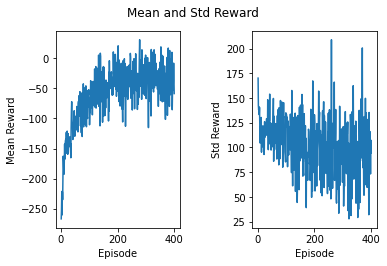

100%|██████████| 100/100 [1:08:35<00:00, 41.15s/it]


In [22]:
#import time
#from itertools import count
#from collections import OrderedDict
#num_epis_total = 0    # number of played episodes
#start_time = time.time()

done_iters = 400
iters = 100
x_axis = list(range(1,len(avg_reward_list)+1))

for i in trange(iters):

    # Generating paths.
    paths = rollout(env, act, gamma, gae_param)
    
    # Load feed_dict and old_weights
    observations = np.concatenate([path["observations"] for path in paths])
    old_mu_eval  = np.concatenate([path["mu_evals"] for path in paths])
    old_V_eval   = np.concatenate([path["values"] for path in paths])
    actions      = np.concatenate([path["actions"] for path in paths])
    old_probs    = np.concatenate([path["action_probs"] for path in paths])
    c_returns    = np.concatenate([path["cumulative_returns"] for path in paths])
    GAE          = np.concatenate([path["GAE"] for path in paths])
    
    feed_dict_policy = {obs_ph: observations,
                        old_mu_ph: old_mu_eval,
                        actions_ph: actions,
                        old_probs_ph: old_probs,
                        advantage_ph: GAE,
                        c_returns_ph: c_returns,
                        p_beta_ph: p_beta,}

    for _ in range(grad_iters):
        # Train Policy loss
        sess.run(train_Policy_loss, feed_dict = feed_dict_policy)

    feed_dict_value = {obs_ph: observations,
                       c_returns_ph: c_returns,
                       old_V_ph: old_V_eval,
                       v_beta_ph: v_beta}

    for _ in range(grad_iters):
        # Train State Value loss
        sess.run(train_V_loss, feed_dict = feed_dict_value)
    
    feed_dict_loss = feed_dict_policy
    for k in feed_dict_value.keys():
        feed_dict_loss[k] = feed_dict_value[k]

    # Report current progress
    kl_policy_v, kl_value_v = sess.run(losses, feed_dict = feed_dict_loss)
    
    # Update soft constraint regulizers
    if kl_policy_v >= 1.5 * eps:
        p_beta *= 2
    if kl_policy_v <= eps / 1.5:
        p_beta /= 2

    if kl_value_v >= 1.5 * eps:
        v_beta *= 2
    if kl_value_v <= eps / 1.5:
        v_beta /= 2
    
    episode_rewards = np.array([path["reward"] for path in paths])
    
    avg_reward_list.append(episode_rewards.mean())
    std_reward_list.append(episode_rewards.std())

    #Print Figure
    x_axis.append(done_iters + i + 1)

    clear_output(True)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Mean and Std Reward')
    ax1.plot(x_axis, avg_reward_list)
    ax2.plot(x_axis, std_reward_list)
    ax1.set(xlabel='Episode', ylabel='Mean Reward')
    ax2.set(xlabel='Episode', ylabel='Std Reward')
    fig.tight_layout(pad=3.0)
    plt.show()

    #stats = OrderedDict()
    #num_epis_total += len(episode_rewards)

    #stats["Total number of episodes"] = num_epis_total
    #stats["Average sum of rewards per episode"] = episode_rewards.mean()
    #stats["Std of rewards per episode"] = episode_rewards.std()
    #stats["Entropy"] = entropy
    #stats["Time elapsed"] = "%.2f mins" % ((time.time() - start_time)/60.)
    #stats["KL between old and new distribution"] = kl
    #stats["Surrogate loss"] = L_surr

    #for k, v in stats.items():
    #    print(k + ": " + " " * (40 - len(k)) + str(v))

In [23]:
# Save to disk
saver = tf.train.Saver()
saver.save(sess, "model.ckpt")

import pickle

with open("avg_reward_list.txt", "wb") as fp:
    pickle.dump(avg_reward_list, fp)

with open("std_reward_list.txt", "wb") as fp:
    pickle.dump(std_reward_list, fp)    

-31.847312468490106


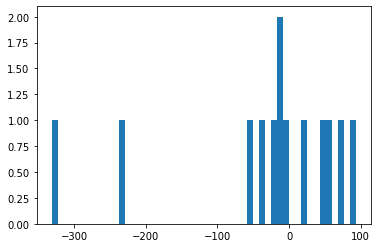

In [24]:
import matplotlib.pyplot as plt

paths = rollout(env, act)
print(np.mean([path['reward'] for path in paths]))

x = [path['reward'] for path in paths]
plt.hist(x, bins = 50)
plt.show()

-----------------

In [25]:
def evaluate(env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """

    game_rewards = []
    for _ in range(n_games):
        # initial observation and memory
        observation = env.reset()

        total_reward = 0
        while True:
            mu_eval, V_eval, action, prob = act(observation)
            observation, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break

        game_rewards.append(total_reward)
    return game_rewards

In [26]:
import gym.wrappers

with gym.wrappers.Monitor(env, directory="videos", force=True) as env_monitor:
    final_rewards = evaluate(env_monitor, n_games=5)

print("Final rewards", np.mean(final_rewards))

Final rewards 20.625324131452764


In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices

# Homework option I: better sampling (10+pts)

In this section, you're invited to implement a better rollout strategy called _vine_.

![img](https://s17.postimg.cc/i90chxgvj/vine.png)

In most gym environments, you can actually backtrack by using states. You can find a wrapper that saves/loads states in [the mcts seminar](https://github.com/yandexdataschool/Practical_RL/blob/master/week10_planning/seminar_MCTS.ipynb).

You can read more about in the [TRPO article](https://arxiv.org/abs/1502.05477) in section 5.2.

The goal here is to implement such rollout policy (we recommend using tree data structure like in the seminar above).
Then you can assign cummulative rewards similar to `get_cummulative_rewards`, but for a tree.

__bonus task__ - parallelize samples using multiple cores

# Homework option II (10+pts)

Let's use TRPO to train evil robots! (pick any of two)
* [MuJoCo robots](https://gym.openai.com/envs#mujoco)
* [Box2d robot](https://gym.openai.com/envs/BipedalWalker-v2)

The catch here is that those environments have continuous action spaces. 

Luckily, TRPO is a policy gradient method, so it's gonna work for any parametric $\pi_\theta(a|s)$. We recommend starting with gaussian policy:

$$\pi_\theta(a|s) = N(\mu_\theta(s),\sigma^2_\theta(s)) = {1 \over \sqrt { 2 \pi {\sigma}_{\theta(s)}^{2} } } e^{ (a - 
\mu_\theta(s))^2 \over 2 {\sigma}_{\theta(s)}^{2} } $$

In the $\sqrt { 2 \pi {\sigma}_{\theta(s)}^{2} }$ clause, $\pi$ means ~3.1415926, not agent's policy.

This essentially means that you will need two output layers:
* $\mu_\theta(s)$, a dense layer with linear activation
* ${\sigma^2}_\theta(s)$, a dense layer with activation tf.exp (to make it positive; like rho from bandits)

For multidimensional actions, you can use fully factorized gaussian (basically a vector of gaussians). Namely,

The Multivariate Gaussian distribution has a pdf that reads 
$$p(x\ |\ \mu,\Sigma)=\frac{1}{(2\pi)^{k/2}\cdot\det(\Sigma)^{1/2}}\exp\left\{ -\frac{1}{2}\left(x-\mu\right)^{T}\Sigma^{-1}\left(x-\mu\right)\right\}$$
_

In the case when the covariance matrix is diagonal $\Sigma=\mathrm{diag}(\sigma_{1}^{2},\dots,\sigma_{k}^{2})$, the pdf simplifies to 
$$p(x\ |\ \mu,\sigma)=\frac{1}{(2\pi)^{k/2}\cdot\prod_{i=1}^{k}\sigma_{i}}\exp\left\{ -\frac{1}{2}\sum_{i=1}^{k}\left(\frac{x_{i}-\mu_{i}}{\sigma_{i}}\right)^{2}\right\}$$
_

Assuming $\mu_{\theta}:S\rightarrow\mathbb{R}^{k}$
and $\sigma_{\theta}:S\rightarrow\mathbb{R}^{k}$ are functions parameterized by $\theta$, we obtain a model-based policy of the form:
$$\pi_{\theta}(a|s)=\mathcal{N}\left(\mu_{\theta}(s),\sigma_{\theta}^{2}(s)\right)=\frac{1}{(2\pi)^{k/2}\cdot\prod_{i=1}^{k}[\sigma_{\theta}(s)]_{i}}\exp\left\{ -\frac{1}{2}\sum_{i=1}^{k}\left(\frac{[a]_{i}-[\mu_{\theta}(s)]_{i}}{[\sigma_{\theta}(s)]_{i}}\right)^{2}\right\}.$$
_

Notice that
$$\ln\pi_{\theta}(a|s)=-\frac{k}{2}\ln(2\pi)-\sum_{i=1}^{k}\ln[\sigma_{\theta}(s)]_{i}-\frac{1}{2}\sum_{i=1}^{k}\left(\frac{[a]_{i}-[\mu_{\theta}(s)]_{i}}{[\sigma_{\theta}(s)]_{i}}\right)^{2}$$
 


For multivariate Guassian distributions, we have

\begin{eqnarray*}
KL\left(\pi_{t}(\cdot|s)\:||\:\pi_{t+1}(\cdot|s)\right)&=&\frac{1}{2}\left\{ -k+Tr\left[\Sigma_{t+1}^{-1}\Sigma_{t}\right]+(\mu_{t+1}-\mu_{t})^{T}\Sigma_{t+1}^{-1}(\mu_{t+1}-\mu_{t})+\ln\frac{\det(\Sigma_{t+1})}{\det(\Sigma_{t})}\right\} \\(\Sigma_{t+1}=\Sigma_{t})&=&\frac{1}{2}\left\{ (\mu_{t+1}-\mu_{t})^{T}\Sigma_{t+1}^{-1}(\mu_{t+1}-\mu_{t})\right\} \\&=&\frac{1}{2}\sum_{i=1}^{k}\left(\frac{[\mu_{t+1}-\mu_{t}]_{i}}{[\sigma_{t+1}]_{i}}\right)^{2}
\end{eqnarray*}


__bonus task__: compare performance of continuous action space method to action space discretization

In [ ]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

def normal(s, mu, sigma_sq):
    a = np.exp( - np.square(s - mu) / (2 * sigma_sq) )
    b = 1 / np.sqrt(2 * sigma_sq * np.pi)
    return a*b

mu = 0
sigma = 0.1
sigma_sq = np.square(sigma)

x = normal(mu, mu, sigma_sq)
print(x)

# pdf
pdf = [normal(mu + i/1000, mu, sigma_sq) for i in range(-100,100)]
plt.plot(pdf)
plt.show()

# histogram of samples
samples = mu + sigma * np.random.randn(10000)
hist = plt.hist(samples, 100)
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
from scipy.stats import multivariate_normal


dim_action = 2

@tf.function
def tf_normal(s, mu, sigma_sq):
    exp_term   = tf.math.exp( - tf.reduce_sum( tf.math.square(s - mu) / (2 * sigma_sq), axis = -1) )
    norm_const = tf.math.sqrt( tf.math.pow(2 * np.pi, dim_action) * tf.reduce_prod(sigma_sq, axis=-1) )
    return exp_term / norm_const


s        = 0.9 * tf.ones( (2,3,dim_action), dtype = tf.float32 )
mu       = tf.ones( (2,3,dim_action), dtype = tf.float32 )
sigma_sq = (0.1)**2 * tf.ones((2,3,dim_action), dtype = tf.float32)


x = tf_normal(s, mu, sigma_sq)
print(x)

y = multivariate_normal.pdf( s[0,0], mu[0,0], sigma_sq[0,0] )
print(y)

In [ ]:
def normal(s, mu, sigma_sq):
    exp_term   = np.exp( - np.sum( tf.math.square(s - mu) / (2 * sigma_sq), axis = -1) )
    norm_const = np.sqrt( np.pow(2 * np.pi, dim_action) * np.prod(sigma_sq, axis=-1) )
    return exp_term / norm_const

s        = 0.9 * np.ones( (2,3,dim_action), dtype = np.float32 )
mu       = np.ones( (2,3,dim_action), dtype = np.float32 )
sigma_sq = (0.1)**2 * np.ones((2,3,dim_action), dtype = np.float32)


x = tf_normal(s, mu, sigma_sq)
print(x)

y = multivariate_normal.pdf( s[0,0], mu[0,0], sigma_sq[0,0] )
print(y)